# 🏥 Cardiovascular Risk Prediction - Hackathon Demo

**Simple AI system that predicts heart risk from patient data**

## How it works:
1. Load patient CSV file
2. Train simple model 
3. Predict risk
4. Show explainable AI results


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("✅ Ready to predict heart risk!")


✅ Ready to predict heart risk!


In [25]:
# Load patient time series data
patient_data = pd.read_csv('patient_data.csv')
patient_data['date'] = pd.to_datetime(patient_data['date'])
patient_data['datetime'] = pd.to_datetime(patient_data['date'].astype(str) + ' ' + patient_data['time'])

print("📊 Patient Time Series Data:")
print(f"   Records: {len(patient_data)} measurements")
print(f"   Date range: {patient_data['date'].min().date()} to {patient_data['date'].max().date()}")
print(f"   Measurements per day: {len(patient_data) // len(patient_data['date'].unique())}")
print("\nFirst few measurements:")
print(patient_data.head())
print("\nLast few measurements:")
print(patient_data.tail())


📊 Patient Time Series Data:
   Records: 30 measurements
   Date range: 2024-01-01 to 2024-01-10
   Measurements per day: 3

First few measurements:
        date      time patient_id  age gender diabetes hypertension  \
0 2024-01-01  08:30:00       P001   67   Male      Yes          Yes   
1 2024-01-01  14:00:00       P001   67   Male      Yes          Yes   
2 2024-01-01  20:00:00       P001   67   Male      Yes          Yes   
3 2024-01-02  08:30:00       P001   67   Male      Yes          Yes   
4 2024-01-02  14:00:00       P001   67   Male      Yes          Yes   

   systolic_bp  diastolic_bp  heart_rate  ...  glucose  medication_adherence  \
0          140            82          70  ...      140                    85   
1          138            80          68  ...      138                    85   
2          142            84          72  ...      142                    85   
3          142            84          72  ...      142                    80   
4          140           

In [26]:
# Create simple training data (fake data for demo)
np.random.seed(42)
n = 1000

# Generate fake patient data with additional features
fake_data = {
    'age': np.random.normal(65, 15, n),
    'systolic_bp': np.random.normal(140, 20, n),
    'diastolic_bp': np.random.normal(85, 15, n),
    'heart_rate': np.random.normal(80, 15, n),
    'cholesterol': np.random.normal(220, 50, n),
    'glucose': np.random.normal(120, 30, n),
    'medication_adherence': np.random.normal(80, 20, n),
    'exercise_minutes': np.random.normal(200, 100, n),
    'diet_score': np.random.normal(6, 2, n),
    'stress_level': np.random.normal(5, 2, n),
    'weight_kg': np.random.normal(75, 10, n),
    'oxygen_saturation': np.random.normal(97, 2, n),
    'temperature_c': np.random.normal(37, 0.5, n),
    'sleep_hours': np.random.normal(7, 1.5, n)
}

# Create risk labels (high risk if multiple factors are bad)
risk_factors = (
    (fake_data['systolic_bp'] > 140).astype(int) +
    (fake_data['diastolic_bp'] > 90).astype(int) +
    (fake_data['cholesterol'] > 200).astype(int) +
    (fake_data['glucose'] > 126).astype(int) +
    (fake_data['medication_adherence'] < 80).astype(int) +
    (fake_data['exercise_minutes'] < 150).astype(int) +
    (fake_data['diet_score'] < 5).astype(int) +
    (fake_data['stress_level'] > 7).astype(int) +
    (fake_data['oxygen_saturation'] < 95).astype(int) +
    (fake_data['temperature_c'] > 37.5).astype(int)
)

# High risk if 4+ factors
fake_data['risk'] = (risk_factors >= 4).astype(int)

# Convert to DataFrame
train_data = pd.DataFrame(fake_data)
print(f"✅ Created training data: {len(train_data)} patients")
print(f"   High risk patients: {train_data['risk'].sum()}")
print(f"   Low risk patients: {len(train_data) - train_data['risk'].sum()}")
print(f"   Features: {len(fake_data)-1} (including new vitals)")


✅ Created training data: 1000 patients
   High risk patients: 484
   Low risk patients: 516
   Features: 14 (including new vitals)


In [27]:
# Train simple model with enhanced features
features = ['age', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol', 
           'glucose', 'medication_adherence', 'exercise_minutes', 'diet_score', 'stress_level',
           'weight_kg', 'oxygen_saturation', 'temperature_c', 'sleep_hours']

X = train_data[features]
y = train_data['risk']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
model = LogisticRegression(random_state=42)
model.fit(X_scaled, y)

print("✅ Model trained!")
print(f"   Features used: {len(features)}")
print(f"   Model accuracy: {model.score(X_scaled, y):.2f}")
print(f"   New features: weight, oxygen saturation, temperature, sleep hours")


✅ Model trained!
   Features used: 14
   Model accuracy: 0.81
   New features: weight, oxygen saturation, temperature, sleep hours


In [28]:
# Extract features from time series data
# Use latest values and trends
latest_data = patient_data.iloc[-1]  # Most recent measurement
trend_data = patient_data.tail(21)   # Last 7 days (3 measurements per day) for trends

# Calculate trends
bp_trend = np.polyfit(range(len(trend_data)), trend_data['systolic_bp'], 1)[0]
hr_trend = np.polyfit(range(len(trend_data)), trend_data['heart_rate'], 1)[0]
adherence_trend = np.polyfit(range(len(trend_data)), trend_data['medication_adherence'], 1)[0]
oxygen_trend = np.polyfit(range(len(trend_data)), trend_data['oxygen_saturation'], 1)[0]
temp_trend = np.polyfit(range(len(trend_data)), trend_data['temperature_c'], 1)[0]

# Create feature vector with all features
patient_features = np.array([
    latest_data['age'],
    latest_data['systolic_bp'],
    latest_data['diastolic_bp'],
    latest_data['heart_rate'],
    latest_data['cholesterol'],
    latest_data['glucose'],
    latest_data['medication_adherence'],
    latest_data['exercise_minutes'],
    latest_data['diet_score'],
    latest_data['stress_level'],
    latest_data['weight_kg'],
    latest_data['oxygen_saturation'],
    latest_data['temperature_c'],
    latest_data['sleep_hours']
]).reshape(1, -1)

patient_scaled = scaler.transform(patient_features)
risk_prob = model.predict_proba(patient_scaled)[0, 1]
risk_level = "HIGH" if risk_prob > 0.7 else "MEDIUM" if risk_prob > 0.3 else "LOW"

print(f"🎯 RISK PREDICTION FOR PATIENT {latest_data['patient_id']}:")
print(f"   Risk Score: {risk_prob:.2f}")
print(f"   Risk Level: {risk_level}")
print(f"   Probability of heart problems: {risk_prob*100:.1f}%")
print(f"\n📈 TRENDS (last 7 days):")
print(f"   Blood Pressure trend: {bp_trend:.1f} mmHg/day")
print(f"   Heart Rate trend: {hr_trend:.1f} bpm/day")
print(f"   Medication adherence trend: {adherence_trend:.1f}%/day")
print(f"   Oxygen saturation trend: {oxygen_trend:.1f}%/day")
print(f"   Temperature trend: {temp_trend:.1f}°C/day")


🎯 RISK PREDICTION FOR PATIENT P001:
   Risk Score: 1.00
   Risk Level: HIGH
   Probability of heart problems: 100.0%

📈 TRENDS (last 7 days):
   Blood Pressure trend: 0.8 mmHg/day
   Heart Rate trend: 0.8 bpm/day
   Medication adherence trend: -1.6%/day
   Oxygen saturation trend: -0.1%/day
   Temperature trend: 0.1°C/day


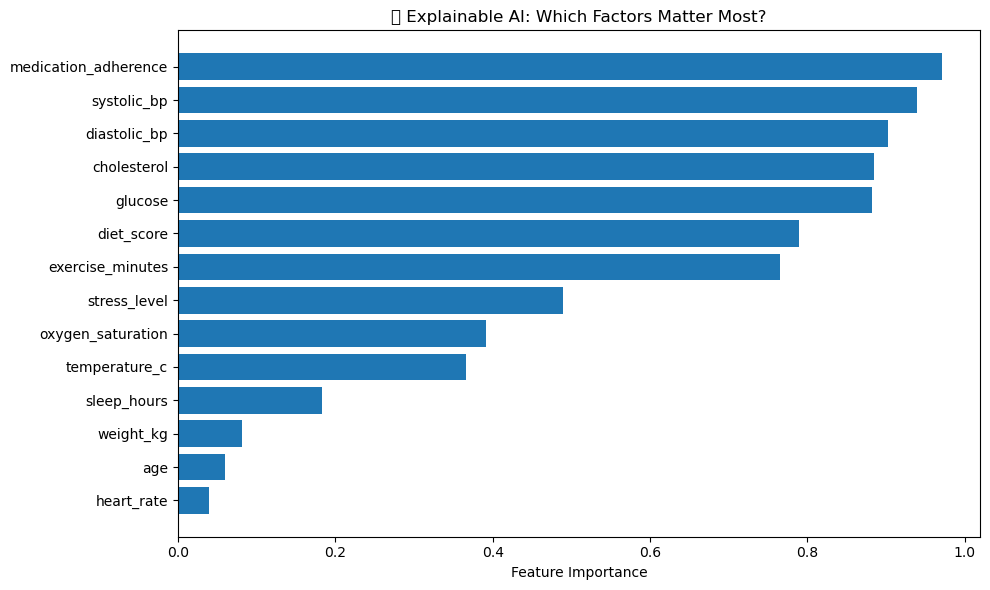

📊 TOP RISK FACTORS:
   1. glucose: 0.883
   2. cholesterol: 0.885
   3. diastolic_bp: 0.903
   4. systolic_bp: 0.939
   5. medication_adherence: 0.971


In [29]:
# Explainable AI - Show which features matter most
feature_importance = abs(model.coef_[0])
feature_names = features

# Sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('🔍 Explainable AI: Which Factors Matter Most?')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("📊 TOP RISK FACTORS:")
for i, (_, row) in enumerate(importance_df.tail(5).iterrows()):
    print(f"   {i+1}. {row['feature']}: {row['importance']:.3f}")


In [30]:
# Generate comprehensive patient report
print("="*70)
print("🏥 CARDIOVASCULAR RISK REPORT")
print("="*70)
print(f"Patient ID: {latest_data['patient_id']}")
print(f"Age: {latest_data['age']} years")
print(f"Gender: {latest_data['gender']}")
print(f"Diabetes: {latest_data['diabetes']}")
print(f"Hypertension: {latest_data['hypertension']}")
print(f"Report Date: {latest_data['date'].strftime('%Y-%m-%d')} at {latest_data['time']}")
print()
print("📈 CURRENT VITAL SIGNS:")
print(f"   Blood Pressure: {latest_data['systolic_bp']}/{latest_data['diastolic_bp']} mmHg")
print(f"   Heart Rate: {latest_data['heart_rate']} bpm")
print(f"   Oxygen Saturation: {latest_data['oxygen_saturation']}%")
print(f"   Temperature: {latest_data['temperature_c']}°C")
print(f"   Weight: {latest_data['weight_kg']} kg")
print(f"   Cholesterol: {latest_data['cholesterol']} mg/dL")
print(f"   Glucose: {latest_data['glucose']} mg/dL")
print()
print("📊 TREND ANALYSIS (7-day):")
print(f"   BP Trend: {bp_trend:+.1f} mmHg/day {'📈' if bp_trend > 0 else '📉'}")
print(f"   HR Trend: {hr_trend:+.1f} bpm/day {'📈' if hr_trend > 0 else '📉'}")
print(f"   Adherence Trend: {adherence_trend:+.1f}%/day {'📈' if adherence_trend > 0 else '📉'}")
print(f"   Oxygen Trend: {oxygen_trend:+.1f}%/day {'📈' if oxygen_trend > 0 else '📉'}")
print(f"   Temperature Trend: {temp_trend:+.1f}°C/day {'📈' if temp_trend > 0 else '📉'}")
print()
print("💊 LIFESTYLE:")
print(f"   Medication Adherence: {latest_data['medication_adherence']}%")
print(f"   Exercise: {latest_data['exercise_minutes']} min/week")
print(f"   Diet Score: {latest_data['diet_score']}/10")
print(f"   Stress Level: {latest_data['stress_level']}/10")
print(f"   Sleep Hours: {latest_data['sleep_hours']} hours")
print()
print("🎯 RISK ASSESSMENT:")
print(f"   Risk Score: {risk_prob:.2f}")
print(f"   Risk Level: {risk_level}")
print(f"   Recommendation: {'🚨 Immediate intervention needed' if risk_level == 'HIGH' else '⚠️ Enhanced monitoring recommended' if risk_level == 'MEDIUM' else '✅ Continue current care'}")
print("="*70)


🏥 CARDIOVASCULAR RISK REPORT
Patient ID: P001
Age: 67 years
Gender: Male
Diabetes: Yes
Hypertension: Yes
Report Date: 2024-01-10 at 20:00:00

📈 CURRENT VITAL SIGNS:
   Blood Pressure: 164/101 mmHg
   Heart Rate: 94 bpm
   Oxygen Saturation: 96.3%
   Temperature: 38.6°C
   Weight: 73.6 kg
   Cholesterol: 262 mg/dL
   Glucose: 164 mg/dL

📊 TREND ANALYSIS (7-day):
   BP Trend: +0.8 mmHg/day 📈
   HR Trend: +0.8 bpm/day 📈
   Adherence Trend: -1.6%/day 📉
   Oxygen Trend: -0.1%/day 📉
   Temperature Trend: +0.1°C/day 📈

💊 LIFESTYLE:
   Medication Adherence: 40%
   Exercise: 0 min/week
   Diet Score: 1/10
   Stress Level: 10/10
   Sleep Hours: 4.7 hours

🎯 RISK ASSESSMENT:
   Risk Score: 1.00
   Risk Level: HIGH
   Recommendation: 🚨 Immediate intervention needed


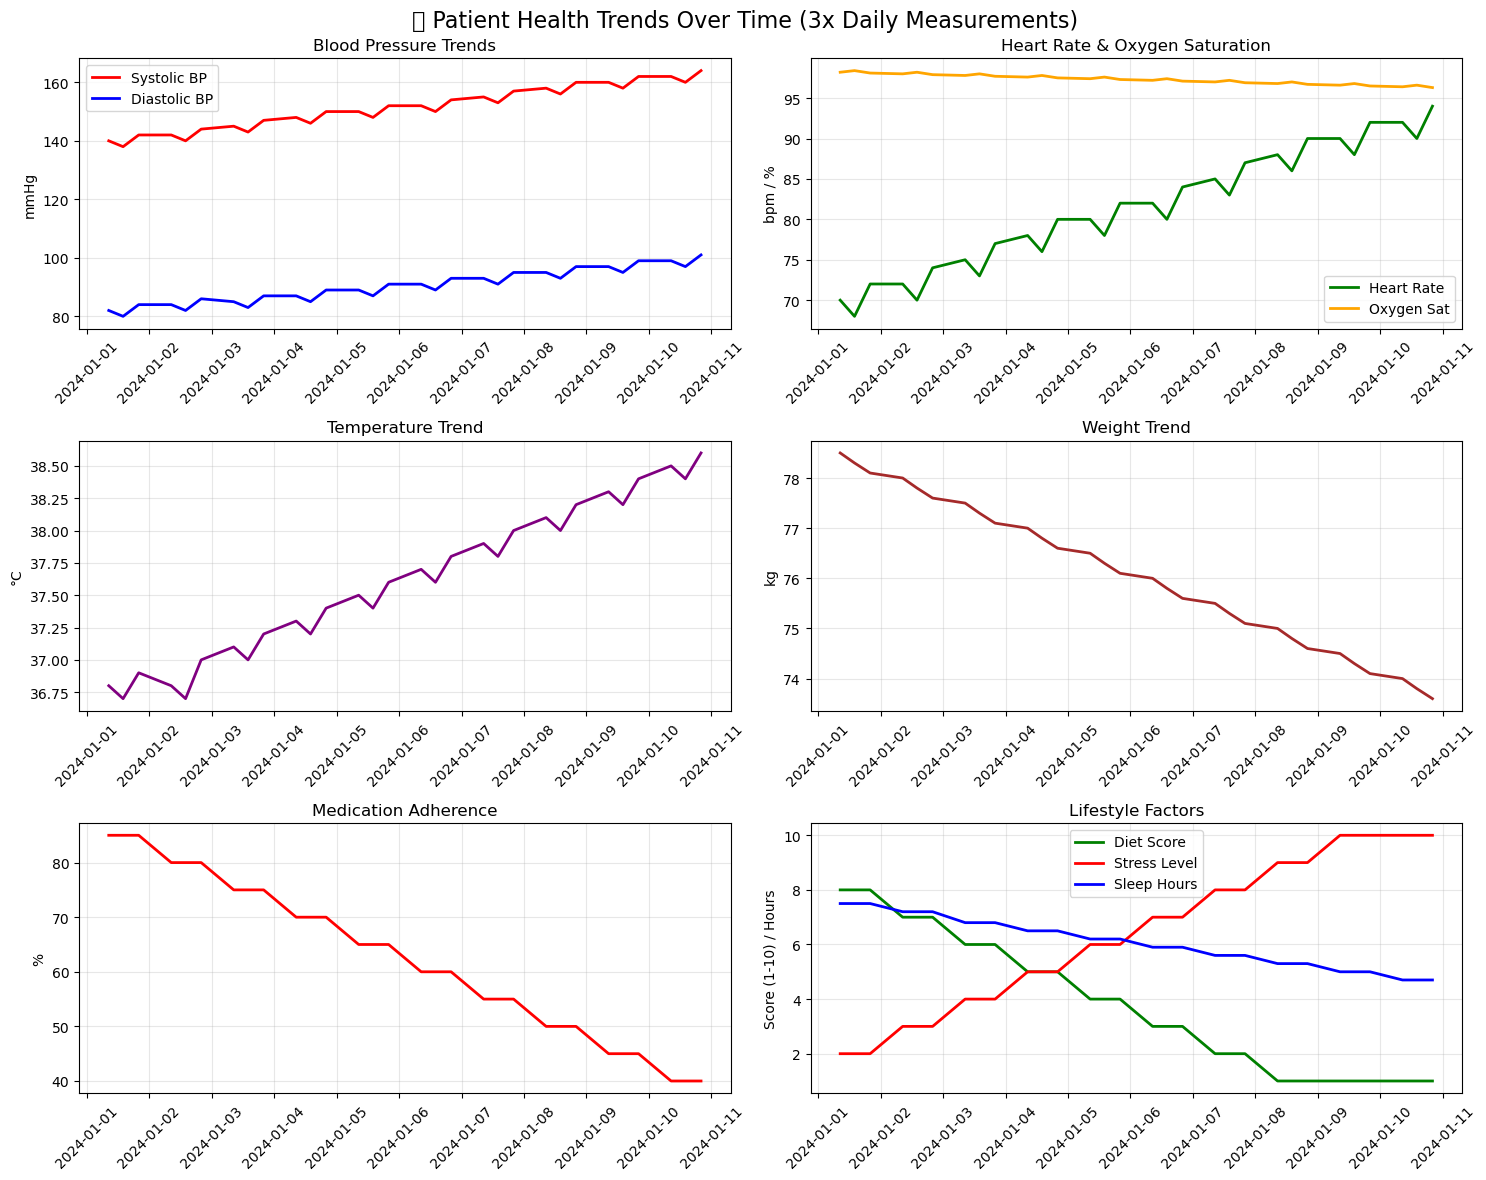

📈 TREND SUMMARY:
   Blood Pressure: Rising (+0.8 mmHg/day)
   Heart Rate: Rising (+0.8 bpm/day)
   Medication Adherence: Declining (-1.6%/day)
   Oxygen Saturation: Declining (-0.1%/day)
   Temperature: Rising (+0.1°C/day)


In [31]:
# Plot time series trends with enhanced data
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('📊 Patient Health Trends Over Time (3x Daily Measurements)', fontsize=16)

# Blood Pressure
axes[0,0].plot(patient_data['datetime'], patient_data['systolic_bp'], 'r-', label='Systolic BP', linewidth=2)
axes[0,0].plot(patient_data['datetime'], patient_data['diastolic_bp'], 'b-', label='Diastolic BP', linewidth=2)
axes[0,0].set_title('Blood Pressure Trends')
axes[0,0].set_ylabel('mmHg')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Heart Rate & Oxygen
axes[0,1].plot(patient_data['datetime'], patient_data['heart_rate'], 'g-', label='Heart Rate', linewidth=2)
axes[0,1].plot(patient_data['datetime'], patient_data['oxygen_saturation'], 'orange', label='Oxygen Sat', linewidth=2)
axes[0,1].set_title('Heart Rate & Oxygen Saturation')
axes[0,1].set_ylabel('bpm / %')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Temperature & Weight
axes[1,0].plot(patient_data['datetime'], patient_data['temperature_c'], 'purple', linewidth=2)
axes[1,0].set_title('Temperature Trend')
axes[1,0].set_ylabel('°C')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(patient_data['datetime'], patient_data['weight_kg'], 'brown', linewidth=2)
axes[1,1].set_title('Weight Trend')
axes[1,1].set_ylabel('kg')
axes[1,1].grid(True, alpha=0.3)

# Medication Adherence
axes[2,0].plot(patient_data['datetime'], patient_data['medication_adherence'], 'red', linewidth=2)
axes[2,0].set_title('Medication Adherence')
axes[2,0].set_ylabel('%')
axes[2,0].grid(True, alpha=0.3)

# Lifestyle Factors
axes[2,1].plot(patient_data['datetime'], patient_data['diet_score'], 'green', label='Diet Score', linewidth=2)
axes[2,1].plot(patient_data['datetime'], patient_data['stress_level'], 'red', label='Stress Level', linewidth=2)
axes[2,1].plot(patient_data['datetime'], patient_data['sleep_hours'], 'blue', label='Sleep Hours', linewidth=2)
axes[2,1].set_title('Lifestyle Factors')
axes[2,1].set_ylabel('Score (1-10) / Hours')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

# Format x-axis for all subplots
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("📈 TREND SUMMARY:")
print(f"   Blood Pressure: {'Rising' if bp_trend > 0 else 'Falling'} ({bp_trend:+.1f} mmHg/day)")
print(f"   Heart Rate: {'Rising' if hr_trend > 0 else 'Falling'} ({hr_trend:+.1f} bpm/day)")
print(f"   Medication Adherence: {'Improving' if adherence_trend > 0 else 'Declining'} ({adherence_trend:+.1f}%/day)")
print(f"   Oxygen Saturation: {'Improving' if oxygen_trend > 0 else 'Declining'} ({oxygen_trend:+.1f}%/day)")
print(f"   Temperature: {'Rising' if temp_trend > 0 else 'Falling'} ({temp_trend:+.1f}°C/day)")
